In [1]:
using DataFrames, CSV
using JuMP, Gurobi
using LinearAlgebra, Random, Printf, StatsBase, CategoricalArrays
using Plots
const GRB_ENV = Gurobi.Env(output_flag=0)

# Data preprocessing
dispatch_data = CSV.read("zipcode_incident_data.csv", DataFrame)
wait_time = CSV.read("wait_time_matrix.csv", DataFrame, header=false) |> Matrix
ambulance_capacity = CSV.read("area_capacity_data.csv", DataFrame)
zipcode_to_index = CSV.read("zipcode_to_index.csv", DataFrame)
merged_data = leftjoin(zipcode_to_index, dispatch_data, on=:Zipcode => :ZIPCODE)
sorted_dispatch_data = sort(merged_data, :Index)

# Convert missing values to 0
sorted_dispatch_data.INCIDENT_COUNT .= coalesce.(sorted_dispatch_data.INCIDENT_COUNT, 0)
capacity_vector = ambulance_capacity[!,"CAPACITY"]
demand_vector = sorted_dispatch_data[!,"INCIDENT_COUNT"]

# Model parameters
num_areas = 9
num_zipcodes = 90
Γ_C = 2  # Budget for capacity uncertainty
Γ_D = 3  # Budget for demand uncertainty
Δ_C = 0.1 .* capacity_vector  # 10% deviation in capacity
Δ_D = 0.15 .* demand_vector  # 15% deviation in demand

# Function to build and solve robust min-sum model
function solve_robust_minsum()
    model = Model(Gurobi.Optimizer)
    
    @variable(model, S[1:num_areas, 1:num_zipcodes] >= 0, Int)
    
    @objective(model, Min, sum(S[i,j] * wait_time[i,j] 
               for i in 1:num_areas, j in 1:num_zipcodes))
    
    @constraint(model, [i in 1:num_areas], 
        sum(S[i,j] for j in 1:num_zipcodes) <= capacity_vector[i] - Γ_C * Δ_C[i])
    
    @constraint(model, [j in 1:num_zipcodes], 
        sum(S[i,j] for i in 1:num_areas) >= demand_vector[j] + Γ_D * Δ_D[j])
    
    optimize!(model)
    return model
end

# Function to build and solve robust min-max model
function solve_robust_minmax()
    model = Model(Gurobi.Optimizer)
    
    @variable(model, S[1:num_areas, 1:num_zipcodes] >= 0, Int)
    @variable(model, z[1:num_areas, 1:num_zipcodes], Bin)
    @variable(model, T >= 0)
    
    @objective(model, Min, T)
    
    @constraint(model, [i in 1:num_areas, j in 1:num_zipcodes], 
        S[i,j] <= z[i,j] * 1e6)
    @constraint(model, [i in 1:num_areas, j in 1:num_zipcodes], 
        S[i,j] >= z[i,j])
    
    @constraint(model, [i in 1:num_areas, j in 1:num_zipcodes], 
        T >= wait_time[i,j] * z[i,j])
    
    @constraint(model, [i in 1:num_areas], 
        sum(S[i,j] for j in 1:num_zipcodes) <= capacity_vector[i] - Γ_C * Δ_C[i])
    
    @constraint(model, [j in 1:num_zipcodes], 
        sum(S[i,j] for i in 1:num_areas) >= demand_vector[j] + Γ_D * Δ_D[j])
    
    optimize!(model)
    return model
end

solve_robust_minmax (generic function with 1 method)

In [2]:
# Function to calculate performance metrics
function calculate_metrics(S, wait_time)
    response_times = [S[i,j] * wait_time[i,j] 
                     for i=1:num_areas, j=1:num_zipcodes if S[i,j] > 0]
    
    return Dict(
        "avg_response_time" => mean(response_times),
        "max_response_time" => maximum(response_times),
        "std_response_time" => std(response_times),
        "station_utilization" => [sum(S[i,:]) / capacity_vector[i] 
                                for i=1:num_areas]
    )
end


calculate_metrics (generic function with 1 method)

In [3]:
# Solve both models
minsum_model = solve_robust_minsum()
minmax_model = solve_robust_minmax()

# Get solution values
minsum_S = value.(minsum_model[:S])
minmax_S = value.(minmax_model[:S])

# Calculate metrics
minsum_metrics = calculate_metrics(minsum_S, wait_time)
minmax_metrics = calculate_metrics(minmax_S, wait_time)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 24.0.0 24A348)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 99 rows, 810 columns and 1620 nonzeros
Model fingerprint: 0xa099231d
Variable types: 0 continuous, 810 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 2648623.0000
Presolve removed 66 rows and 594 columns
Presolve time: 0.00s
Presolved: 33 rows, 216 columns, 432 nonzeros
Variable types: 0 continuous, 216 integer (0 binary)
Found heuristic solution: objective 1518427.0000

Root relaxation: objective 1.454120e+05, 31 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 

Dict{String, Any} with 4 entries:
  "std_response_time"   => 4360.78
  "station_utilization" => [0.526316, 0.307692, 0.107143, 0.769231, 0.75, 0.75,…
  "max_response_time"   => 20010.0
  "avg_response_time"   => 6475.55

In [4]:
# Visualization functions
function plot_response_times()
    minsum_times = [minsum_S[i,j] * wait_time[i,j] 
                   for i=1:num_areas, j=1:num_zipcodes if minsum_S[i,j] > 0]
    minmax_times = [minmax_S[i,j] * wait_time[i,j] 
                   for i=1:num_areas, j=1:num_zipcodes if minmax_S[i,j] > 0]
    
    p = histogram(minsum_times, alpha=0.5, label="Min-Sum", normalize=true)
    histogram!(minmax_times, alpha=0.5, label="Min-Max", normalize=true)
    title!("Response Time Distribution")
    xlabel!("Response Time")
    ylabel!("Frequency")
    return p
end

plot_response_times (generic function with 1 method)

In [5]:
function plot_station_utilization()
    p = bar(1:num_areas, minsum_metrics["station_utilization"], 
           alpha=0.5, label="Min-Sum")
    bar!(1:num_areas, minmax_metrics["station_utilization"], 
         alpha=0.5, label="Min-Max")
    title!("Station Utilization Comparison")
    xlabel!("Station ID")
    ylabel!("Utilization Rate")
    return p
end

plot_station_utilization (generic function with 1 method)

In [6]:
# Create comparison table
comparison_df = DataFrame(
    Metric = ["Average Response Time", "Maximum Response Time", 
              "Standard Deviation"],
    MinSum = [minsum_metrics["avg_response_time"],
              minsum_metrics["max_response_time"],
              minsum_metrics["std_response_time"]],
    MinMax = [minmax_metrics["avg_response_time"],
              minmax_metrics["max_response_time"],
              minmax_metrics["std_response_time"]]
)

Row,Metric,MinSum,MinMax
,String,Float64,Float64
1,Average Response Time,5385.63,6475.55
2,Maximum Response Time,15936.0,20010.0
3,Standard Deviation,4280.24,4360.78


In [7]:
# Display results
println("\nComparison of Models:")
display(comparison_df)
println("\nObjective Values:")
println("Min-Sum Objective: ", objective_value(minsum_model))
println("Min-Max Objective: ", objective_value(minmax_model))



Comparison of Models:


Row,Metric,MinSum,MinMax
,String,Float64,Float64
1,Average Response Time,5385.63,6475.55
2,Maximum Response Time,15936.0,20010.0
3,Standard Deviation,4280.24,4360.78



Objective Values:
Min-Sum Objective: 145412.0
Min-Max Objective: 7968.0


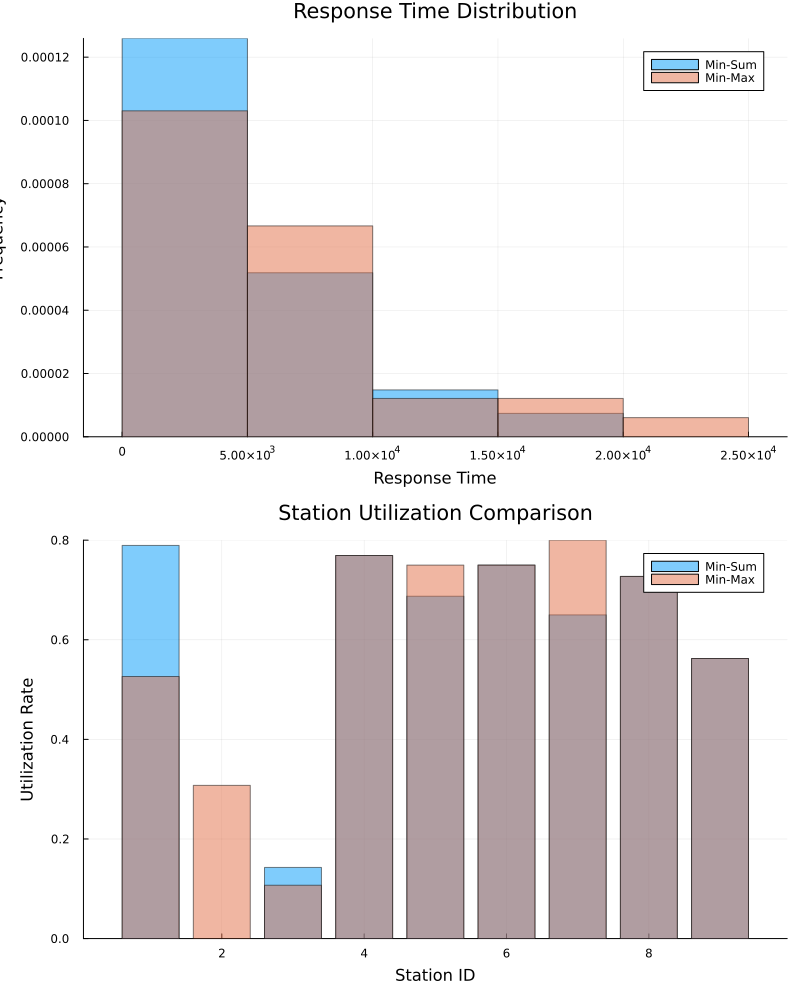

In [8]:
# Plot visualizations
p1 = plot_response_times()
p2 = plot_station_utilization()
plot(p1, p2, layout=(2,1), size=(800,1000))